<a href="https://colab.research.google.com/github/djbrady/multiscalePhaseRetrieval/blob/main/multiscalePhaseRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiscale Phase Retrieval

### David Brady, Timothy J. Schulz, and Chengyu Wang

This notebook implements the phase retrieval algorithms described in "Multiscale Phase Retrieval".

Here we want to reconstruct ${\bf X}$ from the measurement
$${\bf Y}=|{\bf AX}|^2$$
where $${\bf X}\sim CN(0,{\bf I})$$

### Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Error metrics

If $\underline{F}$ is an $N$-element optical field, and an estimate of this field is $\widehat{\underline{F}}$.
### Global-Phase Adjustment
One way to address this is to optimize the MSE over a global phase:
\begin{equation} 
MSE = \underset{\psi}{argmin} \frac{1}{N} \left\| e^{j \psi} \underline{F} - \widehat{\underline{F}} \right\|^2. 
\end{equation}

### Complex-Amplitude Adjustment
If we allow for both an overall phase and amplitude adjustment to the estimate:
\begin{equation} 
MSE = \underset{a,\psi}{argmin} \frac{1}{N} \left\| ae^{j \psi}\underline{F} - \widehat{\underline{F}} \right\|^2. 
\end{equation} 

In [ ]:
def minAngMSE(xt,xest):
    mse=(np.abs(np.vdot(xt,xt))+np.abs(np.vdot(xest,xest))-2*np.abs(np.vdot(xt,xest)));
    return mse/xt.shape[0]
def minAmpMSE(xt,xest):
    mse=(np.abs(np.vdot(xest,xest))-np.abs(np.vdot(xt,xest))**2/np.abs(np.vdot(xt,xt)));
    return mse/xt.shape[0]

## Holography

To understand the quantum limit, consider measurement of the field variable $x$. Unfortunately, at optical and x-ray frequencies, $|x|^2$ is observable, but $x$ is not. Holography addresses this challenge by measuring  

\begin{equation}
    y=|r+x|^2
\end{equation}

where $r$ is a known reference signal. The reference and signal waves can be separated in post processing applying various spatial and/or temporal coding strategies. For example, the phase quadrature strategy takes 4 measurements of the form

\begin{align}
      y_1&=|x+r|^2\\
      y_2&=|x-r|^2\\
      y_3&=|x-ir|^2\\
      y_4&=|x+ir|^2
\end{align}

We can estimate $x$ according to 

\begin{align}
      \Re \left \lbrace x_{\rm est}\right \rbrace&={{y_1-y_2}\over {4 r}}\\
    \Im \left \lbrace x_{\rm est}\right \rbrace&={{y_3-y_4}\over {4 r}}
\end{align}

where we assume $r$ is real.

In [ ]:
def run_holography(n,NP,ref=100000,num_trial = 10000):
    # This function returns the mean square error for phase quadrature holographic measurement of n modes with random Gaussian distribution
    # Input:
    # n: signal dimension
    # NP: expected number of photons if the signal amplitude is 1
    # ref: reference beam amplitude, assuming a real number
    # num_trial: number of simulations
    
    for photons in NP:
        Error_ang = 0
        Error_amp = 0
        Error_cor = 0
        for ct in range(num_trial):
            xt = np.random.randn(n,1)+1j*np.random.randn(n,1);
            xt = np.sqrt(photons)*xt/np.sqrt(2.)
            a = np.random.poisson(np.power(np.abs(ref+xt/2),2));
            b = np.random.poisson(np.power(np.abs(ref-xt/2),2));
            c = np.random.poisson(np.power(np.abs(ref-1j*xt/2),2));
            d = np.random.poisson(np.power(np.abs(ref+1j*xt/2),2));
            xest = 2 * ((a-b) + 1j*(c-d))/(4*ref)
            Error_ang += minAngMSE(xt,xest)
            Error_amp += minAmpMSE(xt,xest) 
        Error_ang = Error_ang/num_trial
        Error_amp = Error_amp/num_trial
        print('When n = %d, photons = %d'%(n,photons))
        print('MSE after global phase adjustment is %f, after complex-amplitude adjustment is %f'%(Error_ang,Error_amp))   


In [ ]:
run_holography(2,[10000,1000,100])

When n = 2, photons = 10000
MSE after global phase adjustment is 0.758983, after complex-amplitude adjustment is 0.504430
When n = 2, photons = 1000
MSE after global phase adjustment is 0.749349, after complex-amplitude adjustment is 0.495143
When n = 2, photons = 100
MSE after global phase adjustment is 0.751809, after complex-amplitude adjustment is 0.504196


## Random connections (L = 2)
For each group of L = 2 modes, three measurements are taken with the transform


\begin{equation}
{\bf A}= 
{1\over \sqrt{3}}\left[
  \begin{array}{cc}
  {1} & {1}\\
  {1}&{\exp(i\frac{2\pi}{3})} \\
  {1}&{\exp(i\frac{4\pi}{3})} 
  \end{array}
\right].
\end{equation}
We consider fields with $2^k$ modes, and each mode is measured $2k$ times.

In [ ]:
def randM(n,m):
    
    # This function generates the random connection network given n and m.
    # n: signal dimension
    # m: number of connections for each mode
    
    mat=np.zeros((np.int32(n*m/2),n));
    nc=m*np.ones(n);
    pairs=np.zeros((np.int32(n*m/2),2))
    row=0;
    for pip in range(n-1):
        cons=np.array([pip])
        remain_pair = 0
        for tmp in range(pip+1,n):
            if nc[tmp]>0:
                remain_pair += 1
        if remain_pair < nc[pip]:
            return randM(n,m)

        while nc[pip]>0:
            cp=np.random.randint(pip+1,n);
            if (nc[cp]>0 and not (cp in cons)):
                cons=np.append(cons,cp);
                nc[pip]=nc[pip]-1;
                nc[cp]=nc[cp]-1;
                mat[row,pip]=1;
                mat[row,cp]=-1;
                row=row+1;
            if row==(np.int32(n*m/2)):
                nc[:]=0
    if not np.min(np.sum(abs(mat),0)) == np.max(np.sum(abs(mat),0)):
        return randM(n,m)
    return mat

In [ ]:
def run_multiscale_global(k,ratio,A,photons = 10000,num_trial = 100,starter_learning_rate = 0.1,decay_step = 50,decay_rate = 0.7,num_iter = 200,returnError = False):
    # this function returns the mean square error for measurement of field consisting of 2^k modes, modes are randomly connected to p=ratio log n othermodes for pairwise measurement
    #  according to matrix A.
    ## Key inputs:
    # k: consider signal dimension n = 2^k
    # ratio: number of connections for each mode is m = ratio * log2(n) = ratio * k
    # A: measurement matrix
    
    ## dimensions
    n = 2**k
    m = ratio * k
    num_pair = int(n * m/2)
    
    ## measurement matrix
    A_real = tf.constant(np.real(A),dtype = tf.float32)
    A_imag = tf.constant(np.imag(A),dtype = tf.float32) 
    
    ## allow generating random mapping for n > 2**12 from n = 2**12. 
    if k < 13:
        if os.path.isfile('measurement_matrix/n_%d_m_%d.txt'%(n,m)):
            with open('measurement_matrix/n_%d_m_%d.txt'%(n,m), "rb") as fp:
                Connection_indices = pickle.load(fp)
        else:
            mat = randM(n,m)
            Connection_indices = []
            for i in range(num_pair):
                Connection_indices.append([2*i,np.where(mat[i,:] == 1)[0][0]])
                Connection_indices.append([2*i+1,np.where(mat[i,:] == -1)[0][0]])
            with open('measurement_matrix/n_%d_m_%d.txt'%(n,m), "wb") as fp:
                pickle.dump(Connection_indices, fp)
    else:
        if os.path.isfile('measurement_matrix/n_%d_m_%d.txt'%(n,m)):
            with open('measurement_matrix/n_%d_m_%d.txt'%(n,m), "rb") as fp:
                Connection_indices = pickle.load(fp)
        else:
            with open('measurement_matrix/n_%d_m_%d.txt'%(2**(k-1),ratio*(k-1)), "rb") as fp:
                Connection_indices = pickle.load(fp)
            length = len(Connection_indices)
            for i in range(length):
                Connection_indices.append([Connection_indices[i][0]+length,Connection_indices[i][1]+2**(k-1)])
            if ratio == 1:
                IDX = len(Connection_indices)
                for i in range(2**(k-1)):
                    Connection_indices.append([IDX+2*i,i])
                    Connection_indices.append([IDX+2*i+1,i+2**(k-1)])
            elif ratio == 2:
                shuffle1 = np.arange(0,2**(k-1))
                shuffle2 = np.arange(0,2**(k-1))
                while np.sum(shuffle1 == shuffle2)>0:
                    np.random.shuffle(shuffle1)
                    np.random.shuffle(shuffle2)
                IDX = len(Connection_indices)
                for i in range(2**(k-1)):
                    Connection_indices.append([IDX+4*i,i])
                    Connection_indices.append([IDX+4*i+1,2**(k-1)+shuffle1[i]])
                    Connection_indices.append([IDX+4*i+2,i])
                    Connection_indices.append([IDX+4*i+3,2**(k-1)+shuffle2[i]])
                    
            elif ratio == 3:
                shuffle1 = np.arange(0,2**(k-1))
                shuffle2 = np.arange(0,2**(k-1))
                shuffle3 = np.arange(0,2**(k-1))
                while np.sum(shuffle1 == shuffle2) + np.sum(shuffle1 == shuffle3) + np.sum(shuffle2 == shuffle3)>0:
                    np.random.shuffle(shuffle1)
                    np.random.shuffle(shuffle2)
                    np.random.shuffle(shuffle3)
                IDX = len(Connection_indices)
                for i in range(2**(k-1)):
                    Connection_indices.append([IDX+6*i,i])
                    Connection_indices.append([IDX+6*i+1,2**(k-1)+shuffle1[i]])
                    Connection_indices.append([IDX+6*i+2,i])
                    Connection_indices.append([IDX+6*i+3,2**(k-1)+shuffle2[i]])
                    Connection_indices.append([IDX+6*i+4,i])
                    Connection_indices.append([IDX+6*i+5,2**(k-1)+shuffle3[i]])     
            else:
                print('Ratio not supported')
                
            with open('measurement_matrix/n_%d_m_%d.txt'%(n,m), "wb") as fp:
                pickle.dump(Connection_indices, fp)
    values = [1.0] * 2 * num_pair
    Connection_matrix = tf.sparse.SparseTensor(Connection_indices, values, dense_shape=[2 * num_pair,n]) 

    xest_real = tf.Variable(np.random.randn(n,1),dtype = tf.float32)
    xest_imag = tf.Variable(np.random.randn(n,1),dtype = tf.float32)
    xest_pair_real =  tf.reshape(tf.sparse.sparse_dense_matmul(Connection_matrix,xest_real, adjoint_a=False, adjoint_b=False, name=None),[num_pair,2,1])
    xest_pair_imag =  tf.reshape(tf.sparse.sparse_dense_matmul(Connection_matrix,xest_imag, adjoint_a=False, adjoint_b=False, name=None),[num_pair,2,1])
    Y = tf.compat.v1.placeholder(tf.float32, shape=(None,3,1))
    yest_real = tf.matmul(A_real,xest_pair_real) - tf.matmul(A_imag,xest_pair_imag)
    yest_imag = tf.matmul(A_real,xest_pair_imag) + tf.matmul(A_imag,xest_pair_real)  
    loss = tf.norm(Y-tf.sqrt(yest_real*yest_real + yest_imag*yest_imag))
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate,global_step, decay_step,decay_rate, staircase=True)

    optimizer= tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss,global_step=global_step)
    init = tf.compat.v1.global_variables_initializer()
    sess = tf.compat.v1.Session()
    
    
    Error_ang = 0
    Error_amp = 0

    for ct in range(num_trial):
        # Signal
        xt = np.random.randn(n,1)+1j*np.random.randn(n,1)
        xt = np.sqrt(photons)*xt/np.sqrt(2.)
        xt = xt/np.sqrt(m) ## each mode is measured m times       
        
        # Measurement
        y = np.zeros(np.hstack([num_pair, A.shape[0],1]))
        for i in range(num_pair):
            y[i,:,0] = np.sqrt(np.random.poisson(np.power(np.abs(np.matmul(A,[xt[Connection_indices[2*i][1]][0],xt[Connection_indices[2*i+1][1]][0]])),2)))

        sess.run(init)
        for iter_ in range(num_iter):
            sess.run(optimizer,feed_dict={Y: y})
        xest = 1j * xest_imag.eval(sess) + xest_real.eval(sess)     
        Error_ang += minAngMSE(xt*np.sqrt(m),xest*np.sqrt(m))
        Error_amp += minAmpMSE(xt*np.sqrt(m),xest*np.sqrt(m))
    Error_ang = Error_ang/num_trial
    Error_amp = Error_amp/num_trial
    print('When n = %d, each mode is measured m = %d times, photons = %d'%(n,m,photons))
    print('MSE after global phase adjustment is %f, after complex-amplitude adjustment is %f'%(Error_ang,Error_amp)) 
    if returnError == True:
        return Error_amp,Error_ang
   

In [ ]:
A = np.array([[1,1], [1, np.exp(1j*2*np.pi/3)],[1,np.exp(1j*4*np.pi/3)]]);
A = np.divide(A,np.sqrt(np.sum(abs(A)*abs(A),0,keepdims=True)))
for i in range(5):
    run_multiscale_global(i + 3,2,A,photons = 10000,num_trial = 100,starter_learning_rate = 50.0,decay_step = 50,decay_rate = 0.5,num_iter = 200)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
When n = 8, each mode is measured m = 6 times, photons = 10000
MSE after global phase adjustment is 1.144499, after complex-amplitude adjustment is 1.086176
When n = 16, each mode is measured m = 8 times, photons = 10000
MSE after global phase adjustment is 1.274176, after complex-amplitude adjustment is 1.247131
When n = 32, each mode is measured m = 10 times, photons = 10000
MSE after global phase adjustment is 1.336253, after complex-amplitude adjustment is 1.326698
When n = 64, each mode is measured m = 12 times, photons = 10000
MSE after global phase adjustment is 1.323647, after complex-amplitude adjustment is 1.317514
When n = 128, each mode is measured m = 14 times, photons = 10000
MSE after global phase adjustment is 1.345483, after complex-amplitude adjustment is 1.339576


## Multiscale strategy
The field is divided into several rank 0 blocks. Phase retrieval is applied to each block, and the cross-blocks connections are used to retrieve the relative phases between blocks.

In [ ]:
def run_multiscale(k,base,ratio,A,phase_ratio = 0.95,photons = 10000, num_trial = 100,starter_learning_rate = 50.0, decay_step = 50, decay_rate = 0.5, num_iter = 200,returnError = False):
    ## this function returns the mean square error for block wise phase retrieval according to the strategy outlined in the paper. 
    ## Key Inputs:
    # k: consider signal dimension 2^k
    # base: size of the rank 0 block 2^base
    # ratio: number of connections for each point is ratio * log2(n)
    # A: measurement matrix
    # phase_ratio: the ratio of the energy that is used on within-block connections
    
    ## dimensions
    n = 2 ** k 
#     phase_ratio = 0.95
    m = ratio * k
    n_base = 2 ** base
    m_base = ratio * base

    num_pair = int(n * m/2)
    num_pair_base = int(n_base * m_base/2)


    ## measurement matrix
    A_real = tf.constant(np.real(A),dtype = tf.float32)
    A_imag = tf.constant(np.imag(A),dtype = tf.float32)


    ## Base Connection
    if os.path.isfile('measurement_matrix/base_n_%d_m_%d.txt'%(n_base,m_base)):
#         print('measurement_matrix/base_n_%d_m_%d.txt'%(n_base,m_base))
        with open('measurement_matrix/base_n_%d_m_%d.txt'%(n_base,m_base), "r") as file:
            Connection_indices = eval(file.readline())
    else:
        mat = randM(n_base,m_base)
        Connection_indices = []
        for i in range(num_pair_base):
            Connection_indices.append([2*i,np.where(mat[i,:] == 1)[0][0]])
            Connection_indices.append([2*i+1,np.where(mat[i,:] == -1)[0][0]])
        with open('measurement_matrix/base_n_%d_m_%d.txt'%(n_base,m_base), "w") as file:
            file.write(str(Connection_indices))
    values = [1.0] * 2 * num_pair_base
    Connection_matrix = tf.sparse.SparseTensor(Connection_indices, values, dense_shape=[2 * num_pair_base,n_base]) 

    xest_real = tf.Variable(np.random.randn(n_base,1),dtype = tf.float32)
    xest_imag = tf.Variable(np.random.randn(n_base,1),dtype = tf.float32)
    xest_pair_real =  tf.reshape(tf.sparse.sparse_dense_matmul(Connection_matrix,xest_real, adjoint_a=False, adjoint_b=False, name=None),[num_pair_base,2,1])
    xest_pair_imag =  tf.reshape(tf.sparse.sparse_dense_matmul(Connection_matrix,xest_imag, adjoint_a=False, adjoint_b=False, name=None),[num_pair_base,2,1])
    yest_real = tf.matmul(A_real,xest_pair_real) - tf.matmul(A_imag,xest_pair_imag)
    yest_imag = tf.matmul(A_real,xest_pair_imag) + tf.matmul(A_imag,xest_pair_real)

    Y = tf.compat.v1.placeholder(tf.float32, shape=(None,A.shape[0],1))
    loss = tf.norm(Y-tf.sqrt(yest_real*yest_real + yest_imag*yest_imag))
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate,global_step, decay_step,decay_rate, staircase=True)

    optimizer= tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss,global_step=global_step)


    ## Cross-cell connection 
    if os.path.isfile('measurement_matrix/cross_n_%d_m_%d.txt'%(n_base,m_base)):
        with open('measurement_matrix/cross_n_%d_m_%d.txt'%(n_base,m_base), "r") as file:
            Connection_indices_cross = eval(file.readline())
    else:
        Connection_indices_cross = []
        if ratio == 1:
            for i in range(n_base):
                Connection_indices_cross.append([2*i,i])
                Connection_indices_cross.append([2*i+1,i+n_base])
        elif ratio == 2:
            shuffle1 = np.arange(0,n_base)
            shuffle2 = np.arange(0,n_base)
            while np.sum(shuffle1 == shuffle2)>0:
                np.random.shuffle(shuffle1)
                np.random.shuffle(shuffle2)
            for i in range(n_base):
                Connection_indices_cross.append([4*i,i])
                Connection_indices_cross.append([4*i+1,n_base+shuffle1[i]])
                Connection_indices_cross.append([4*i+2,i])
                Connection_indices_cross.append([4*i+3,n_base+shuffle2[i]])
        with open('measurement_matrix/cross_n_%d_m_%d.txt'%(n_base,m_base), "w") as file:
            file.write(str(Connection_indices_cross))

    values_cross = [1.0] * ratio * n_base * 2
    Connection_matrix_cross = tf.sparse.SparseTensor(Connection_indices_cross, values_cross, dense_shape=[ratio * n_base * 2,2*n_base]) 

    x1_abs = tf.compat.v1.placeholder(tf.float32, shape=(n_base,1))
    x1_phase = tf.compat.v1.placeholder(tf.float32, shape=(n_base,1))
    x2_real = tf.compat.v1.placeholder(tf.float32, shape=(n_base,1))
    x2_imag = tf.compat.v1.placeholder(tf.float32, shape=(n_base,1))
    phase_shift = tf.Variable(np.random.randn(1),dtype = tf.float32)
    x_real = tf.concat([x1_abs * tf.math.cos(x1_phase + phase_shift),x2_real],0)
    x_imag = tf.concat([x1_abs * tf.math.sin(x1_phase + phase_shift),x2_imag],0)
    xest_pair_real_cross =  tf.reshape(tf.sparse.sparse_dense_matmul(Connection_matrix_cross,x_real, adjoint_a=False, adjoint_b=False, name=None),[ratio * n_base,2,1])
    xest_pair_imag_cross =  tf.reshape(tf.sparse.sparse_dense_matmul(Connection_matrix_cross,x_imag, adjoint_a=False, adjoint_b=False, name=None),[ratio * n_base,2,1])
    yest_real_cross = tf.matmul(A_real,xest_pair_real_cross) - tf.matmul(A_imag,xest_pair_imag_cross)
    yest_imag_cross = tf.matmul(A_real,xest_pair_imag_cross) + tf.matmul(A_imag,xest_pair_real_cross)
    Y_cross = tf.compat.v1.placeholder(tf.float32, shape=(None,A.shape[0],1))
    loss_cross = tf.norm(Y_cross-tf.sqrt(yest_real_cross*yest_real_cross + yest_imag_cross*yest_imag_cross))
    optimizer_cross= tf.compat.v1.train.AdamOptimizer(1.0).minimize(loss_cross,global_step=global_step)
    
    init = tf.compat.v1.global_variables_initializer()
    sess = tf.compat.v1.Session()
    
    Error_ang = 0
    Error_amp = 0
    for ct in range(num_trial):

    
        ## signal
        xt = np.random.randn(n,1)+1j*np.random.randn(n,1)
        xt = np.sqrt(photons)*xt/np.sqrt(2.)
        xt1 = xt * np.sqrt(phase_ratio)/np.sqrt(ratio * base)
        xt2 = xt * np.sqrt(1-phase_ratio)/np.sqrt(ratio * (k - base))


        init = tf.compat.v1.global_variables_initializer()
        sess = tf.compat.v1.Session()

        xest = np.zeros([n,1])*1j
        for cell_idx in range(2**(k-base)):  
            y = np.zeros(np.hstack([num_pair_base, A.shape[0],1]))
            for i in range(num_pair_base):
                y[i,:,0] = np.sqrt(np.random.poisson(np.power(np.abs(np.matmul(A,[xt1[Connection_indices[2*i][1]+cell_idx * n_base][0],xt1[Connection_indices[2*i+1][1]+cell_idx * n_base][0]])),2)))
            
            sess.run(init)   
            for iter_ in range(num_iter):
                sess.run(optimizer,feed_dict={Y: y})
            xest[cell_idx * n_base:(cell_idx+1)* n_base] = 1j * xest_imag.eval(sess) + xest_real.eval(sess)

        for scale in range(k-base):
            for cell_idx in range(2**(k-base-scale-1)):
                PHASE = 0
                for cell_idx_2 in range(2**scale):
                    xt_tmp = np.concatenate([xt2[(cell_idx * 2**(scale+1)+cell_idx_2)*n_base:(cell_idx * 2**(scale+1)+cell_idx_2+1)*n_base,:],xt2[(cell_idx * 2**(scale+1)+cell_idx_2 + 2**scale)*n_base:(cell_idx * 2**(scale+1)+cell_idx_2+ 2**scale+1)*n_base,:]],0)
                    y = np.zeros(np.hstack([n_base*ratio, A.shape[0],1]))
                    for i in range(n_base*ratio):
                        y[i,:,0] = np.sqrt(np.random.poisson(np.power(np.abs(np.matmul(A,[xt_tmp[Connection_indices_cross[2*i][1]][0],xt_tmp[Connection_indices_cross[2*i+1][1]][0]])),2)))
                    
                    sess.run(init)   
                    for iter_ in range(num_iter):
                          sess.run(optimizer_cross,feed_dict={x1_abs:np.abs(xest[(cell_idx * 2**(scale+1)+cell_idx_2)*n_base:(cell_idx * 2**(scale+1)+cell_idx_2+1)*n_base,:]).astype(np.float32),
                                                            x2_real:np.real(xest[(cell_idx * 2**(scale+1)+cell_idx_2 + 2**scale)*n_base:(cell_idx * 2**(scale+1)+cell_idx_2+ 2**scale+1)*n_base,:]),
                                                            x1_phase:np.angle(xest[(cell_idx * 2**(scale+1)+cell_idx_2)*n_base:(cell_idx * 2**(scale+1)+cell_idx_2+1)*n_base,:]).astype(np.float32),
                                                            x2_imag:np.imag(xest[(cell_idx * 2**(scale+1)+cell_idx_2 + 2**scale)*n_base:(cell_idx * 2**(scale+1)+cell_idx_2+ 2**scale+1)*n_base,:]),
                                                            Y_cross: y/np.sqrt(1-phase_ratio)*np.sqrt(ratio * (k - base))* np.sqrt(phase_ratio)/np.sqrt(ratio * base)})
                    PHASE = PHASE + np.exp(1j*phase_shift.eval(sess))
                xest[(cell_idx * 2**(scale+1))*n_base:(cell_idx * 2**(scale+1)+2**scale)*n_base] *= (PHASE/abs(PHASE))

        xest = xest / np.sqrt(phase_ratio)*np.sqrt(ratio * base)
        Error_ang += minAngMSE(xt,xest)
        Error_amp += minAmpMSE(xt ,xest)
    Error_ang = Error_ang/num_trial
    Error_amp = Error_amp/num_trial
    
    print('When n = %d, each mode is measured m = %d times, photons = %d'%(n,m,photons))
    print('MSE after global phase adjustment is %f, after complex-amplitude adjustment is %f'%(Error_ang,Error_amp)) 
    
    if returnError == True:
        return Error_amp,Error_ang
   

In [ ]:
A = np.array([[1,1], [1, np.exp(1j*2*np.pi/3)],[1,np.exp(1j*4*np.pi/3)]]);
A = np.divide(A,np.sqrt(np.sum(abs(A)*abs(A),0,keepdims=True)))
# base 10
run_multiscale_global(10,2,A,photons = 10000,num_trial = 10,starter_learning_rate = 50.0,decay_step = 50,decay_rate = 0.5,num_iter = 200)
for i in range(2):
    run_multiscale(11+i,10,2,A,0.95,num_trial = 10,returnError=False)

When n = 1024, each mode is measured m = 20 times, photons = 10000
MSE after global phase adjustment is 1.360342, after complex-amplitude adjustment is 1.349953
When n = 2048, each mode is measured m = 22 times, photons = 10000
MSE after global phase adjustment is 1.976924, after complex-amplitude adjustment is 1.974396
When n = 4096, each mode is measured m = 24 times, photons = 10000
MSE after global phase adjustment is 1.400889, after complex-amplitude adjustment is 1.398106


## Random connections (L > 2)
For each group of L modes, L measurments are taken with the transform W:

\begin{equation}
\label{eq:wftForm}
W_{q,l} = \frac{1}{\sqrt{Q}} e^{j \frac{2\pi}{Q} q l}.
\end{equation}
We consider fields with $2^k$ modes, and each mode is measured $L*k$ times.

In [ ]:
def elementSampling(ns, m):
    # ns: number of measurements per group
    # m: number of modes per group
    tmp = np.arange(ns)
    H = np.zeros([ns,m])*1j
    for i in range(m):
        H[:,i] = np.exp(1j * i * 2 * np.pi * tmp/ns)/np.sqrt(ns)
    return H



def run_multiple_mode(n,m,p,ns,photons = 10000, num_trial = 100,starter_learning_rate = 10.0,decay_step = 50,decay_rate = 0.7,num_iter = 200):
    # this function returns the MSE for L>2 modes connected in groups according to the strategy outlined in the paper. 
    # n: number of modes
    # m: number of modes per measurement
    # p: scale
    # ns: number of measurement per group of m modes
    # Number of group of m modes: n*p
    # Number of intensity/sample: ns * n * p
    # Each mode will be measured m * p times
    
    tf.compat.v1.reset_default_graph()
    
    ## measurement matrix
    A = elementSampling(ns,m)
    A_real = tf.constant(np.real(A),dtype = tf.float32)
    A_imag = tf.constant(np.imag(A),dtype = tf.float32)
    
    
    ## connections
    num_pair = n * p
    if os.path.isfile('measurement_matrix/multi_mode_mapping_n%d_m%d_p%d.txt'%(n,m,p)):
        with open('measurement_matrix/multi_mode_mapping_n%d_m%d_p%d.txt'%(n,m,p), "rb") as fp:
            Connection_indices = pickle.load(fp)
    else:        
        Connection_indices = []
        IDX = np.arange(n,dtype = np.int32)
        for p_ in range(p):
            np.random.shuffle(IDX)
            tmp = np.lib.stride_tricks.as_strided(np.concatenate([IDX,IDX[0:m-1]]),shape=(n,m), strides=(4,4)).reshape([-1,1])# % n
            tmp2 = np.expand_dims(np.arange(m*n*p_,m*n*(p_+1)),1)
            Connection_indices = Connection_indices + np.concatenate([tmp2,tmp],1).tolist()
        with open('measurement_matrix/multi_mode_mapping_n%d_m%d_p%d.txt'%(n,m,p), "wb") as fp:
            pickle.dump(Connection_indices, fp)
            
            
    values = [1.0] * m * num_pair
    Connection_matrix = tf.sparse.SparseTensor(Connection_indices, values, dense_shape=[m * num_pair,n])
    
    ## graph
    xest_real = tf.Variable(np.random.randn(n,1),dtype = tf.float32)
    xest_imag = tf.Variable(np.random.randn(n,1),dtype = tf.float32)
    xest_pair_real =  tf.reshape(tf.sparse.sparse_dense_matmul(Connection_matrix,xest_real, adjoint_a=False, adjoint_b=False, name=None),[num_pair,m,1])
    xest_pair_imag =  tf.reshape(tf.sparse.sparse_dense_matmul(Connection_matrix,xest_imag, adjoint_a=False, adjoint_b=False, name=None),[num_pair,m,1])
    Y = tf.compat.v1.placeholder(tf.float32, shape=(None,A.shape[0],1))
    yest_real = tf.matmul(A_real,xest_pair_real) - tf.matmul(A_imag,xest_pair_imag)
    yest_imag = tf.matmul(A_real,xest_pair_imag) + tf.matmul(A_imag,xest_pair_real)
    loss = tf.norm(Y-tf.sqrt(yest_real*yest_real + yest_imag*yest_imag))
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate,global_step, decay_step,decay_rate, staircase=True)
    optimizer= tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss,global_step=global_step)
    init = tf.compat.v1.global_variables_initializer()
    sess = tf.compat.v1.Session()
    
    AngError = np.zeros([num_trial])
    for ct in range(num_trial):
        
        ## signal
        xt = np.random.randn(n,1)+1j*np.random.randn(n,1)
        xt = np.sqrt(photons)*xt/np.sqrt(2.)
        xt = xt / np.sqrt(m * p)

        ## measurement
        y = np.zeros(np.hstack([num_pair, A.shape[0],1]))
        for i in range(num_pair):
            ## assume ns = 3
            x_select = []
            for m_ in range(m):
                x_select.append(xt[Connection_indices[m*i + m_][1]][0])
#             y[i,:,0] = np.sqrt(np.random.poisson(np.power(np.abs(np.matmul(A,[xt[Connection_indices[m*i][1]][0],
#                                                                               xt[Connection_indices[m*i+1][1]][0],
#                                                                               xt[Connection_indices[m*i+2][1]][0],
#                                                                               xt[Connection_indices[m*i+3][1]][0]])),2))) 
            y[i,:,0] = np.sqrt(np.random.poisson(np.power(np.abs(np.matmul(A,x_select)),2))) 

        ## phase retrieval 
        sess.run(init)
        for iter_ in range(num_iter):
            sess.run(optimizer,feed_dict={Y: y})
        xest = 1j * xest_imag.eval(sess) + xest_real.eval(sess)
    
        ## evaluation
        AngError[ct] = minAngMSE(xt*np.sqrt(m * p),xest*np.sqrt(m * p))
    plt.hist(AngError)
    plt.show()
    print('Signal dimension: %d, %d modes correlated in each measurement'%(n,m))
    print('Each mode is measured %d time'%(m * p))
    print('Number of measurements per group: %d, total:%d'%(ns,ns *n * p))
    print('Error is',np.mean(AngError))
    return(np.mean(AngError))

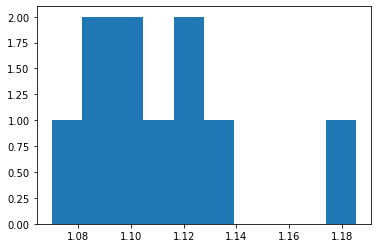

Signal dimension: 1024, 4 modes correlated in each measurement
Each mode is measured 40 time
Number of measurements per group: 4, total:40960
Error is 1.1100574960903031


1.1100574960903031

In [ ]:
run_multiple_mode(n = 2**10,m = 4,p = 10,ns = 4,photons = 10000, num_trial = 10,starter_learning_rate = 50.0,decay_step = 50,decay_rate = 0.5,num_iter = 200)

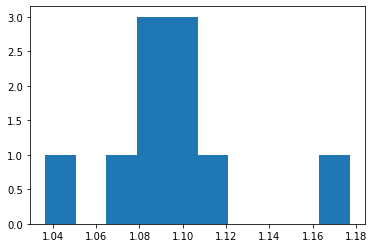

Signal dimension: 1024, 5 modes correlated in each measurement
Each mode is measured 50 time
Number of measurements per group: 5, total:51200
Error is 1.0961493087281269


1.0961493087281269

In [ ]:
run_multiple_mode(n = 2**10,m = 5,p = 10,ns = 5,photons = 10000, num_trial = 10,starter_learning_rate = 50.0,decay_step = 50,decay_rate = 0.5,num_iter = 200)